Types of plots:
Boxplot/violinplot
- per class for each model
- average, but models side by side
Wandb
- loss functions evolution
- loss/dice evolution of top models

Prepare imports and libraries

In [1]:
!pip install pandas 
!pip install tabulate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 29.5 MB/s eta 0:00:00 0:00:01


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
#Pretty Printing Tables
from tabulate import tabulate

Define the paths to the saved models

In [23]:
baseline_enet_path = Path('results/final_results/BASELINES/BASELINE1_ENet')
baseline_enet_name = "Baseline-ENet"
baseline_unet_path = Path('results/final_results/BASELINES/BASELINE_UNet')
baseline_unet_name = "Baseline-UNet"
baseline_unetplusplus_path = Path('results/final_results/BASELINES/BASELINE_UNetPlusPlus')
baseline_unetplusplus_name = "Baseline-UNetPlusPlus"
baseline_deeplab_path = Path('results/final_results/BASELINES/BASELINE_DeepLabV3Plus')
baseline_deeplab_name = "DeepLabV3Plus"

best_enet_path = Path('results/final_results/BESTV2/ENet')
best_enet_name = "Best-ENet"
best_unet_path = Path('results/final_results/BESTV2/UNet')
bestunet_name = "UNet"
best_unetplusplus_path = Path('results/final_results/BESTV2/UNetPlusPlus')
bestunetplusplus_name = "UNetPlusPlus"
best_deeplab_path = Path('results/final_results/BESTV2/DeepLabV3Plus')
bestdeeplab_name = "DeepLabV3Plus"

## Generate the plots Best-ENet VS ENet
Visualize the DSC differences between classes(organs) and at the extremes

In [24]:
def jitter_dots(dots):
    offsets = dots.get_offsets()
    jittered_offsets = offsets
    # only jitter in the x-direction
    jittered_offsets[:, 0] += np.random.uniform(-5, 5, offsets.shape[0])
    # jittered_offsets[:, 1] += np.random.uniform(-0.1, 0.1, offsets.shape[0])
    dots.set_offsets(jittered_offsets)

def plot_dice_scatter(path_to_dice_results, model_name):
    dice_metrics = np.load(path_to_dice_results / 'dice_val.npy')
    print(dice_metrics.shape)
    
    fig, ax1 = plt.subplots()
    
    fig.set_size_inches(10, 8)
    columns = ['Esophagus', 'Heart', 'Trachea', 'Aorta']
    colors = ['b', 'g', 'r', 'y']
    columns_pos = [10, 30, 50, 70]
    
    for i, column in enumerate(columns):
        # dots = plt.scatter(np.full((len(metrics[0]), 1), columns_pos[i]), metrics[0, :, i], s=50, c=c, cmap='plasma')
        
        K = i + 1
        # lower_than_1 = dice_metrics[0, :, K][dice_metrics[0, :, K] < 1.1]
        # dots = plt.scatter(np.full((len(lower_than_1), 1), columns_pos[i]), lower_than_1, alpha=0.5)
        # jitter_dots(dots)
        
        all_scores = dice_metrics[0, :, K]
        perfect_scores = all_scores == 1
        worst_scores = all_scores < 0.1
        # Plot intermediary scores (not perfect and also not worst)
        dots = plt.scatter(np.full((len(all_scores[~perfect_scores & ~worst_scores]), 1), columns_pos[i]),
                           all_scores[~perfect_scores & ~worst_scores], color=colors[i], alpha=0.5)
        
        jitter_dots(dots)
        # Plot perfect & worst scores with a different edge color
        if np.any(perfect_scores):
            perfect_dots = plt.scatter(np.full((len(all_scores[perfect_scores]), 1), columns_pos[i]),
                        all_scores[perfect_scores], color=colors[i], edgecolors='black')
            jitter_dots(perfect_dots)
            worst_dots = plt.scatter(np.full((len(all_scores[worst_scores]), 1), columns_pos[i]),
                        all_scores[worst_scores], color=colors[i], edgecolors='black')
            jitter_dots(worst_dots)
        # Add text annotation with the number of perfect scores
        num_perfect_scores = np.sum(perfect_scores)
        plt.text(columns_pos[i], 1.02, f'N={num_perfect_scores}', ha='center', va='bottom', fontsize=12)
        num_worst_scores = np.sum(worst_scores)
        plt.text(columns_pos[i], -0.07, f'n={num_worst_scores}', ha='center', va='bottom', fontsize=12)
    
    xmin, xmax = plt.xlim()
    
    plt.text(xmax * 0.78, 1.1, f'N = Nr of correct empty GTs \nn = Nr of samples DSC < 0.1', ha='left', va='bottom', fontsize=12, bbox=dict(boxstyle='round,pad=0.5', ec='black', fc='white'))
    plt.axhline(y=0.1, color='black', linestyle='dotted', linewidth=1)
    
    
    plt.xticks(columns_pos, columns, size=12, weight='bold')
    plt.xlabel('Organs', size=12)
    plt.xlim(xmin - 5, xmax + 5)  # make some room to show the jittered dots
    plt.ylabel('Dice score', size=12)
    plt.ylim(-0.1, 1.2)
    plt.title(f'{model_name} - Distribution of Dice Scores by Organ', size=14)
    plt.tight_layout()
    plt.show()

(1, 1967, 5)


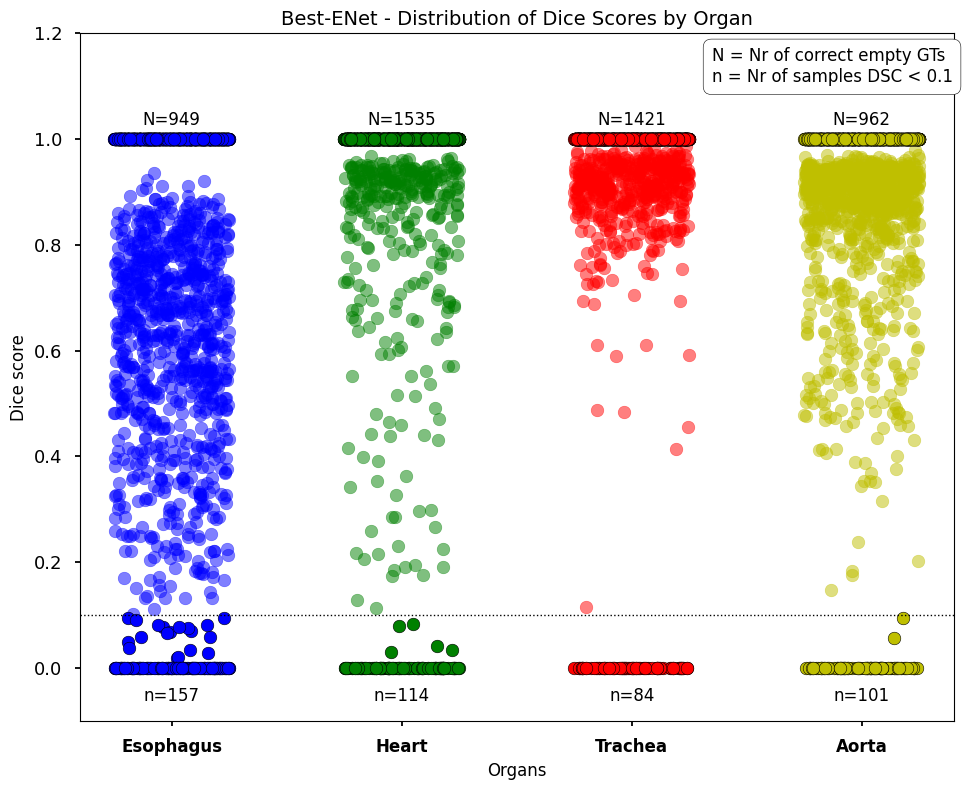

In [25]:
# Plot for Best-ENet
plot_dice_scatter(best_enet_path, best_enet_name)

(1, 1967, 5)


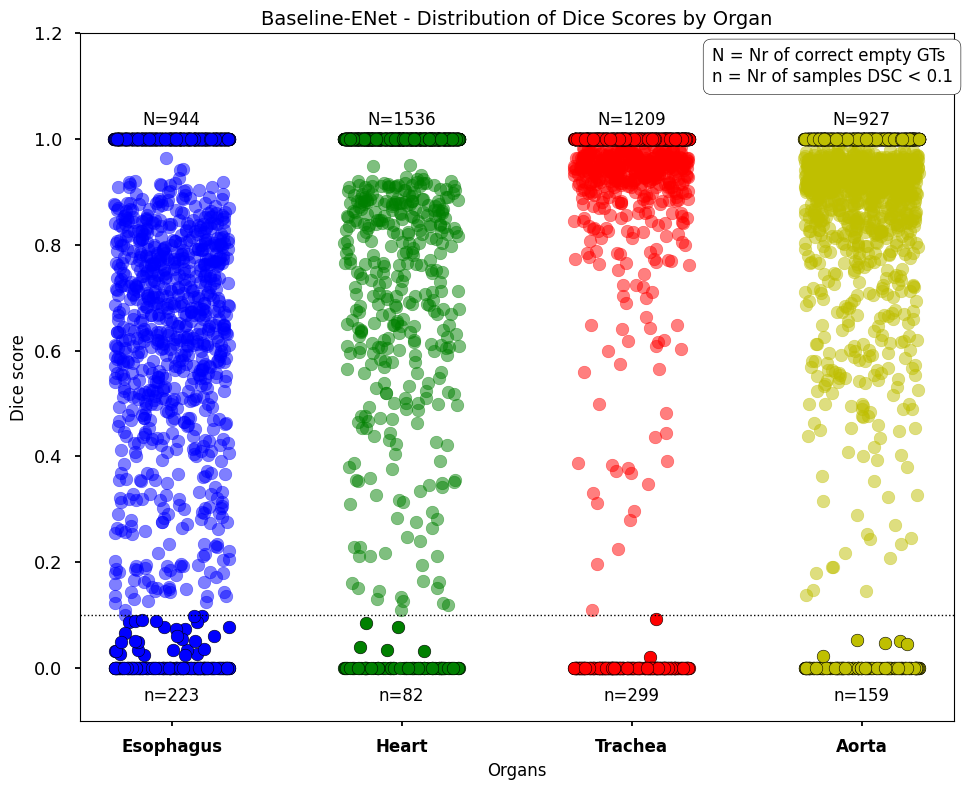

In [26]:
# Plot for Baseline-ENet
plot_dice_scatter(baseline_enet_path, baseline_enet_name)

In [248]:
# Initialize the plot
def plot_dice_violin(path_to_dice_results, model_name):
    dice_metrics = np.load(path_to_dice_results / 'dice_val.npy')
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    columns = ['Esophagus', 'Heart', 'Trachea', 'Aorta']
    columns_pos = np.arange(1, len(columns) + 1)
    
    # Prepare data for each organ
    all_data = []
    perfect_data = []
    data_size = dice_metrics.shape[1]
    
    for i in range(1, 5):
        all_scores = dice_metrics[0, :, i]
        data_smaller_than_1_mask = all_scores < 1 # Only samples < 1
        data_smaller_than_1 = all_scores[data_smaller_than_1_mask]  # All samples for this class
        all_data.append(data_smaller_than_1)
        perfect_data.append(all_scores[~data_smaller_than_1_mask])
    
    # Create the violin plot
    violins = ax.violinplot(
        all_data,
        positions=columns_pos,
        widths=0.6,
        showmeans=False,
        showmedians=False,
        showextrema=False
    )
    
    # Customize violins
    for pc in violins['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
    
    # Overlay boxplot
    boxprops = dict(linestyle='-', linewidth=1.5, color='black', alpha=0.7)
    medianprops = dict(linestyle='-', linewidth=2.5, color='yellow')
    ax.boxplot(
        all_data,
        positions=columns_pos,
        widths=0.3,
        patch_artist=True,
        boxprops=boxprops,
        medianprops=medianprops,
        showfliers=False
    )
    
    # Overlay scatter points (strip plot) with vertical jitter for points close to zero
    for i, data in enumerate(all_data):
        # Jitter the x-values to avoid overlap
        x = np.random.normal(columns_pos[i], 0.04, size=len(data))
        
        # Identify points close to zero (e.g., <= 0.01)
        threshold = 0.005
        close_to_zero = data <= threshold
        not_close_to_zero = ~close_to_zero
        
        # Add positive vertical jitter to points close to zero
        data_jittered = data.copy()
        jitter_amount = np.random.uniform(0.01, 0.02, size=len(data))
        data_jittered[close_to_zero] += jitter_amount[close_to_zero]
        
        # Plot the points
        ax.scatter(x[not_close_to_zero], data_jittered[not_close_to_zero], color='blue', alpha=0.4)
        ax.scatter(x[close_to_zero], data_jittered[close_to_zero], color='blue', alpha=0.4)
        
        perfect_scores = perfect_data[i]
        worst_scores = data < 0.1
        # Add text annotation with the number of perfect scores
        perc_perfect_scores = len(perfect_scores) / data_size * 100
        plt.text(columns_pos[i], 1.02, f'N={perc_perfect_scores:2.1f}', ha='center', va='bottom', fontsize=14)
        perc_worst_scores = np.sum(worst_scores) / data_size * 100
        plt.text(columns_pos[i], -0.07, f'n={perc_worst_scores:2.1f}', ha='center', va='bottom', fontsize=14)
    
    
    plt.axhline(y=0.1, color='black', linestyle='dotted', linewidth=1)
    plt.axhline(y=1.0, color='black', linestyle='dotted', linewidth=1)
    
    # Set x-ticks and labels
    ax.set_xticks(columns_pos, columns, size=14, weight='bold')
    ax.set_xticklabels(columns)
    
    # Set axis labels and title
    ax.set_xlabel('Organs', size=14)
    ax.set_ylabel('Dice Coefficient', size=14)
    ax.set_title(f'{model_name} - Distribution of Dice Scores by Organ', fontsize=18, fontweight='bold')
    
    # Adjust y-axis limits
    ax.set_ylim(-0.1, 1.3)
    
    # Add legend
    from matplotlib.lines import Line2D
    
    legend_elements = [
        Line2D([0], [0], color='#D43F3A', lw=4, label='Data Distribution'),
        Line2D([0], [0], color='black', lw=1.5, label='Interquartile Range'),
        Line2D([0], [0], color='yellow', lw=2.5, label='Median'),
        Line2D([0], [0], marker='o', color='w', label='Data Points',
               markerfacecolor='blue', markersize=5, alpha=0.6),
        Line2D([0], [0], lw=0, color='black', marker=r'$\mathbf{N\%}$', markersize=15, label='Percentage of samples with DSC = 1.0'),
        Line2D([0], [0], lw=0, color='black', marker=r'$\mathbf{n\%}$', markersize=15, label='Percentage of samples with DSC < 0.1')
    ]
    ax.legend(handles=legend_elements, loc='upper right', ncol=2)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Tight layout for better spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()

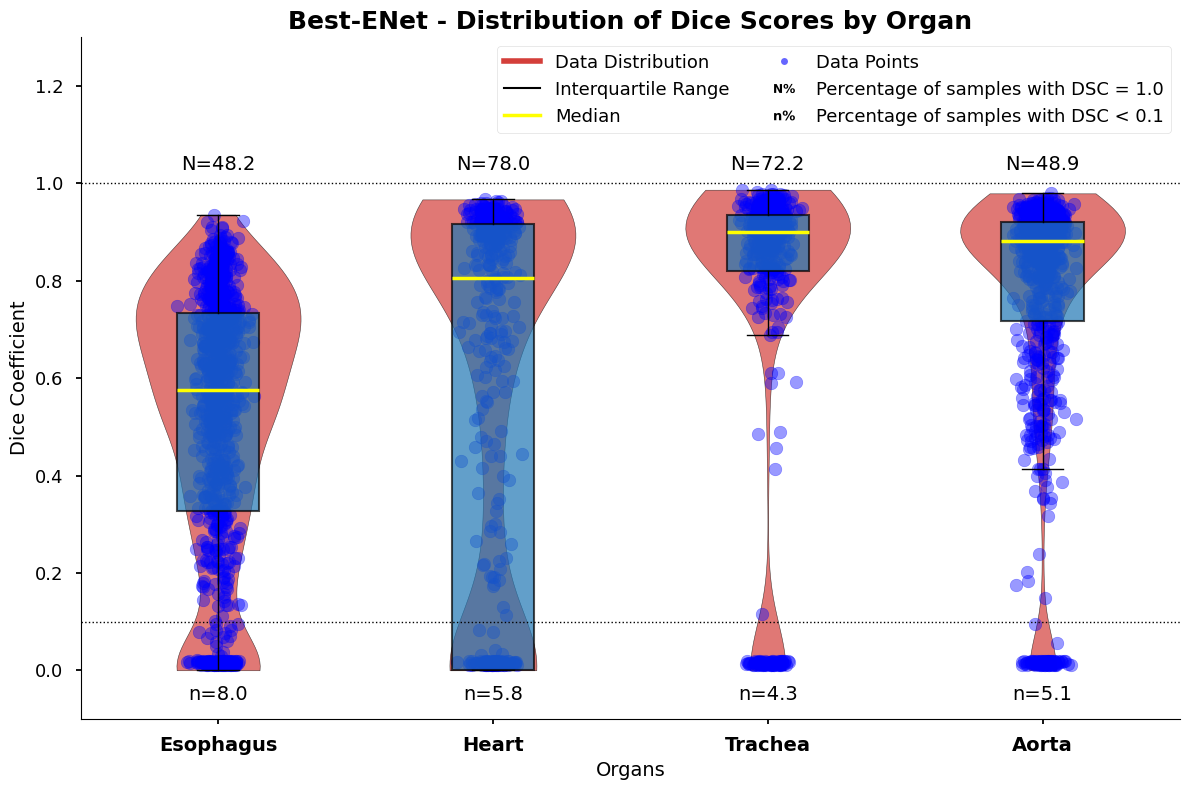

In [249]:
# Plot for Best-ENet
plot_dice_violin(best_enet_path, best_enet_name)

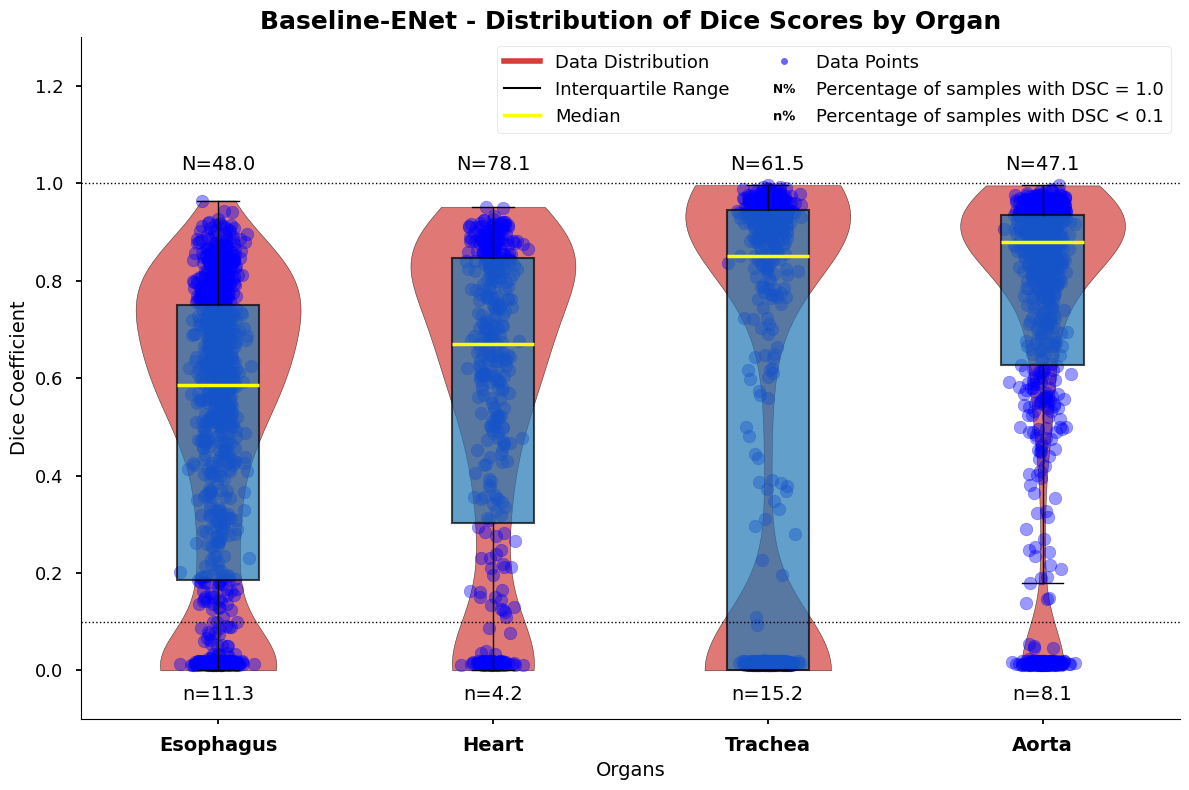

In [250]:
# Plot for Baseline-ENet
plot_dice_violin(baseline_enet_path, baseline_enet_name)

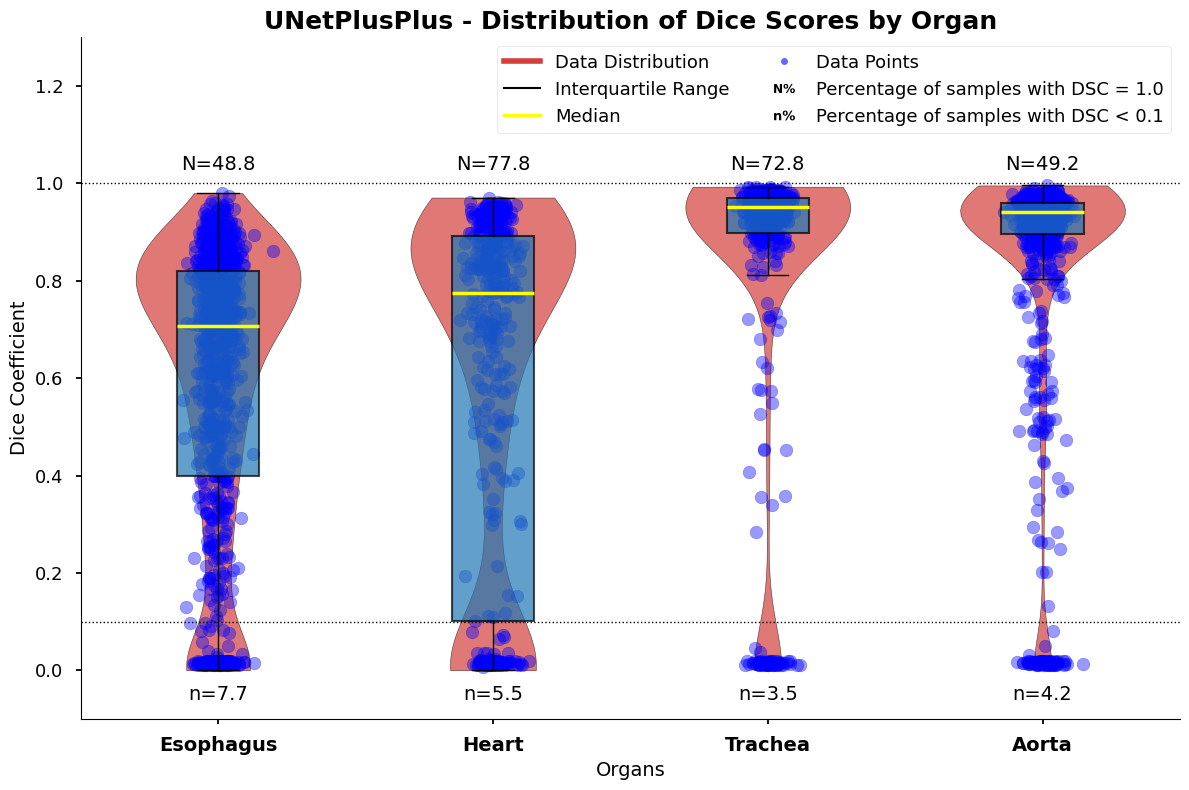

In [251]:
# Plot for best performing model - UNetPlusPlus
plot_dice_violin(best_unetplusplus_path, bestunetplusplus_name)

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def plot_dice_violin_twomodels(path_to_dice_results_model1, path_to_dice_results_model2, model_name1, model_name2):
    # Load the dice metrics for both models
    dice_metrics1 = np.load(Path(path_to_dice_results_model1) / 'dice_val.npy')
    dice_metrics2 = np.load(Path(path_to_dice_results_model2) / 'dice_val.npy')
    
    fig, ax = plt.subplots(figsize=(12, 8))
    columns = ['Esophagus', 'Heart', 'Trachea', 'Aorta']
    columns_pos = np.arange(1, len(columns) + 1)
    
    # Prepare data for each organ for both models
    all_data_model1 = []
    all_data_model2 = []
    means_model1 = []
    means_model2 = []
    counts_perfect_model1 = []
    counts_perfect_model2 = []
    for i in range(1, 5):
        # Model 1 data
        all_scores1 = dice_metrics1[0, :, i]
        data1 = all_scores1[all_scores1 < 1]  # Exclude perfect scores
        all_data_model1.append(data1)
        means_model1.append(np.mean(all_scores1))
        # Count perfect scores for Model 1
        count_perfect1 = np.sum(all_scores1 == 1) / len(all_scores1) * 100
        counts_perfect_model1.append(f'{count_perfect1:2.1f}')
        
        # Model 2 data
        all_scores2 = dice_metrics2[0, :, i]
        data2 = all_scores2[all_scores2 < 1]
        all_data_model2.append(data2)
        means_model2.append(np.mean(all_scores2))
        # Count perfect scores for Model 2
        count_perfect2 = np.sum(all_scores2 == 1) / len(all_scores2) * 100
        counts_perfect_model2.append(f'{count_perfect2:2.1f}')
    
    # Create the violin plots for Model 1
    violins1 = ax.violinplot(
        all_data_model1,
        positions=columns_pos,
        widths=0.6,
        showmeans=False,
        showmedians=False,
        showextrema=False
    )
    
    # Create the violin plots for Model 2
    violins2 = ax.violinplot(
        all_data_model2,
        positions=columns_pos,
        widths=0.6,
        showmeans=False,
        showmedians=False,
        showextrema=False
    )
    
    # Function to create half-violins
    def half_violin(violins, side):
        for b in violins['bodies']:
            m = np.mean(b.get_paths()[0].vertices[:, 0])
            if side == 'left':
                b.get_paths()[0].vertices[:, 0] = np.clip(
                    b.get_paths()[0].vertices[:, 0], -np.inf, m)
            elif side == 'right':
                b.get_paths()[0].vertices[:, 0] = np.clip(
                    b.get_paths()[0].vertices[:, 0], m, np.inf)
            else:
                raise ValueError("side must be 'left' or 'right'")
    
    # Apply the half_violin function to violins
    half_violin(violins1, 'left')
    half_violin(violins2, 'right')
    
    # Customize the violins
    for b in violins1['bodies']:
        b.set_facecolor('#1f77b4')  # Blue color for Model 1
        b.set_edgecolor('black')
        b.set_alpha(0.7)
    for b in violins2['bodies']:
        b.set_facecolor('red')  # Red color for Model 2
        b.set_edgecolor('black')
        b.set_alpha(0.7)
    
    # Plot the means on the corresponding half-violins
    for i, (mean1, mean2) in enumerate(zip(means_model1, means_model2)):
        x_pos = columns_pos[i]
        # Mean for Model 1 (left side)
        ax.plot([x_pos - 0.1, x_pos],
                [mean1, mean1],
                color='blue', linewidth=3)
        # Mean for Model 2 (right side)
        ax.plot([x_pos, x_pos + 0.1],
                [mean2, mean2],
                color='orange', linewidth=3)
    
    # Add counts of perfect scores on top of each half-violin
    for i, (count1, count2) in enumerate(zip(counts_perfect_model1, counts_perfect_model2)):
        x_pos = columns_pos[i]
        weight1, weight2 = 'normal', 'normal'
        if count1 > count2:
            weight1 = 'bold'
        else:
            weight2 = 'bold'
        # Position for Model 1 (left side)
        ax.text(x_pos - 0.1, 1.0, f'{count1}', ha='center', va='bottom', color='blue', fontsize=12, fontdict={'weight': weight1})
        # Position for Model 2 (right side)
        ax.text(x_pos + 0.1, 1.0, f'{count2}', ha='center', va='bottom', color='red', fontsize=12, fontdict={'weight': weight2})
    
    xmin, xmax = plt.xlim()
    ax.text(xmin + 0.08, 1.0, "N %", ha='center', va='bottom', color='black', fontsize=12, fontdict={'weight': 'bold'})
    plt.axhline(y=1.0, color='black', linestyle='solid', linewidth=2, alpha =0.7)
    
    # Set x-ticks and labels
    ax.set_xticks(columns_pos)
    ax.set_xticklabels(columns, fontsize=14, fontweight='bold')
    
    # Set axis labels and title
    ax.set_xlabel('Organs', fontsize=16)
    ax.set_ylabel('Dice Coefficient', fontsize=16)
    ax.set_title(f'{model_name1} vs {model_name2} - Distribution per Organ', fontsize=18, fontweight='bold')
    
    # Adjust y-axis limits
    ax.set_ylim(0, 1.3)
    
    # Add legend
    legend_elements = [
        Patch(facecolor='#1f77b4', edgecolor='black', alpha=0.7, label=f'{model_name1}'),
        Line2D([0], [0], color='blue', lw=2, label=f'{model_name1} Mean'),
        Line2D([0], [0], lw=0, color='black', marker=r'$\mathbf{N\%}$', markersize=15, label='Percentage of samples with DSC = 1.0'),
        Patch(facecolor='red', edgecolor='black', alpha=0.7, label=f'{model_name2}'),
        Line2D([0], [0], color='orange', lw=2, label=f'{model_name2} Mean')
        
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12, frameon=True, ncol=2)
    
    # Enhance design aesthetics
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Tight layout for better spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()


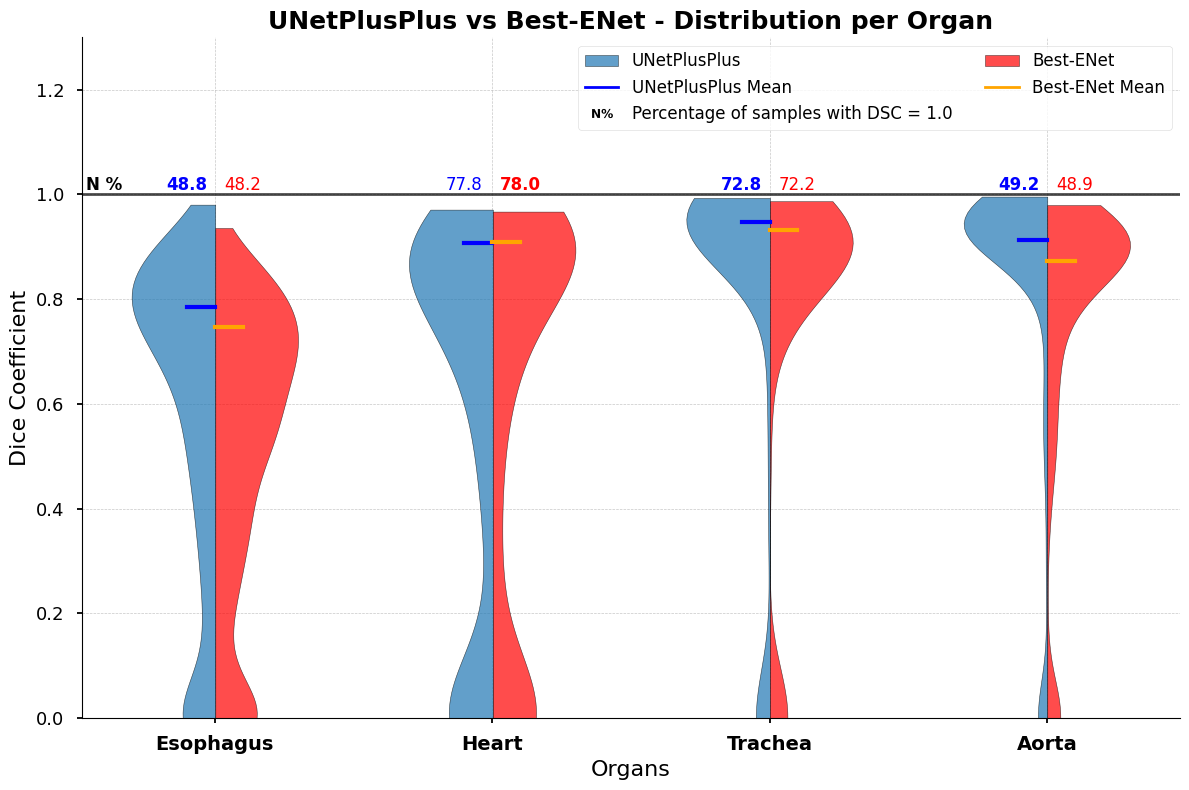

In [177]:
plot_dice_violin_twomodels(best_unetplusplus_path, best_enet_path, bestunetplusplus_name, best_enet_name)

# Generate the plots between models

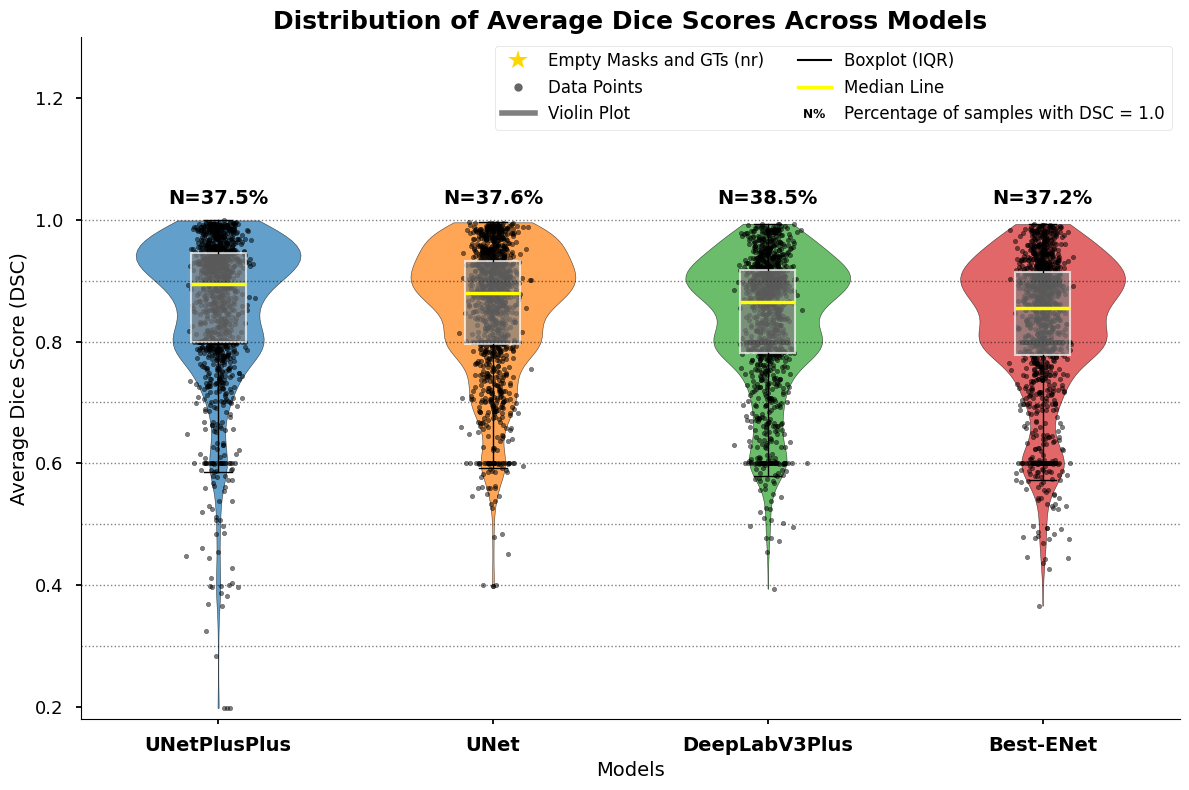

In [252]:

data_enet = np.load(best_enet_path / 'dice_val.npy').mean(axis=2)[0]
data_unet = np.load(best_unet_path / 'dice_val.npy').mean(axis=2)[0]
data_unetplusplus = np.load(best_unetplusplus_path / 'dice_val.npy').mean(axis=2)[0]
data_deeplab = np.load(best_deeplab_path / 'dice_val.npy').mean(axis=2)[0]

model_names = [bestunetplusplus_name, bestunet_name, bestdeeplab_name, best_enet_name]

# Combine all data into a list
all_data_raw = [data_unetplusplus, data_unet, data_deeplab, data_enet]

# Exclude data points where DSC == 1.0 for violin plots
all_data = [data[data < 1.0] for data in all_data_raw]
data_size = len(all_data_raw[0])

# Counts of data points equal to 1.0 for each model
counts_perfect = [np.sum(data == 1.0) / data_size * 100 for data in all_data_raw]

# Initialize the plot
fig, ax = plt.subplots(figsize=(12, 8))
positions = np.arange(1, len(model_names) + 1)

# Create the violin plot
violins = ax.violinplot(
    all_data,
    positions=positions,
    widths=0.6,
    showmeans=False,
    showmedians=False,
    showextrema=False
)

# Customize violins
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each model
for violin, color in zip(violins['bodies'], colors):
    violin.set_facecolor(color)
    violin.set_edgecolor('black')
    violin.set_alpha(0.7)

# Overlay boxplot
boxprops = dict(linestyle='-', linewidth=1.5, color='white', alpha=0.7, facecolor='grey')
medianprops = dict(linestyle='-', linewidth=2.5, color='yellow')
ax.boxplot(
    all_data,
    positions=positions,
    widths=0.2,
    patch_artist=True,
    boxprops=boxprops,
    medianprops=medianprops,
    showfliers=False
)

# Add scatter plots for individual data points
for i, data in enumerate(all_data):
    # Jitter the x-values to prevent overlap
    x = np.random.normal(positions[i], 0.04, size=len(data))
    ax.scatter(x, data, color='black', alpha=0.5, s=10)

# Visualize the number of data points equal to 1.0
for i, count in enumerate(counts_perfect):
    if count > 0:
        x_pos = positions[i]
        # Add text next to the star indicating the count
        ax.text(
            x_pos,
            1.02,
            f'N={count:2.1f}%',
            ha='center',
            va='bottom',
            fontsize=14,
            fontweight='bold'
        )

# Set x-ticks and labels
ax.set_xticks(positions)
ax.set_xticklabels(model_names, size=14, weight='bold')

# Set axis labels and title
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Average Dice Score (DSC)', fontsize=14)
ax.set_title('Distribution of Average Dice Scores Across Models', fontsize=18, fontweight='bold')

# Adjust y-axis limits
ax.set_ylim(0.18, 1.3)

# Add grid lines for better readability
ax.yaxis.grid(False)
for i in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.axhline(y=i, color='black', linestyle='dotted', linewidth=1, alpha=0.5)
ax.set_axisbelow(True)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='*', color='w', label='Empty Masks and GTs (nr)', markerfacecolor='gold', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Data Points', markerfacecolor='black', markersize=6, alpha=0.6),
    Line2D([0], [0], color='grey', lw=4, label='Violin Plot'),
    Line2D([0], [0], color='black', lw=1.5, label='Boxplot (IQR)'),
    Line2D([0], [0], color='yellow', lw=2.5, label='Median Line'),
    Line2D([0], [0], lw=0, color='black', marker=r'$\mathbf{N\%}$', markersize=15, label='Percentage of samples with DSC = 1.0')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12, frameon=True, ncol=2)

# Enhance design aesthetics
plt.style.use('seaborn-v0_8-talk')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout to prevent clipping of ylabel/title
plt.tight_layout()

# Show the plot
plt.show()


# Generate the table with all the metrics

In [14]:
models = {
    best_enet_name: best_enet_path,
    bestunet_name: best_unet_path,
    bestunetplusplus_name: best_unetplusplus_path,
    bestdeeplab_name: best_deeplab_path,
    baseline_enet_name: baseline_enet_path
}

# metrics to load
metrics = ['ahd_val.npy', 'assd_val.npy', 'dice_val.npy', 'jaccard_val.npy', 
           'loss_val.npy', 'precision_val.npy', 'recall_val.npy']

data = {}

# Looping through models and metrics, loading the .npy files, and computing the average values
for model_name, model_path in models.items():
    data[model_name] = {}
    for metric in metrics:
        metric_path = os.path.join(model_path, metric)
        # print(f"Checking: {metric_path}")
        if os.path.exists(metric_path):
            # Load the metric values from the .npy file
            metric_values = np.load(metric_path)
            
            # Determine the dimensions of the metric values
            if metric_values.ndim > 1:
                # For multi-dimensional arrays, mean across all dimensions
                average_value = np.mean(metric_values)
            else:
                # For 1D arrays, directly compute the mean
                average_value = np.mean(metric_values)
            
            data[model_name][metric.split('_')[0]] = average_value
        else:
            print(f"File not found: {metric_path}")
            data[model_name][metric.split('_')[0]] = None


df = pd.DataFrame(data).T

print(df)

                    ahd      assd      dice   jaccard      loss  precision  \
Best-ENet      2.742107  2.166990  0.891511  0.862474  0.035329   0.914676   
UNet           2.771870  2.264241  0.907404  0.879686  0.035914   0.930479   
UNetPlusPlus   2.291798  1.803354  0.910718  0.887011  0.021815   0.951200   
DeepLabV3Plus  2.499627  1.951321  0.897961  0.869384  0.034429   0.926061   
Baseline-ENet  2.682290  2.112514  0.861146  0.833327  0.033512   0.903413   

                 recall  
Best-ENet      0.919628  
UNet           0.925079  
UNetPlusPlus   0.919765  
DeepLabV3Plus  0.913217  
Baseline-ENet  0.903102  


In [15]:

# Convert DataFrame to a list of lists
table = [df.columns.tolist()] + df.reset_index().values.tolist()

# Print the table using tabulate with 'fancy_grid' format
pretty_table = tabulate(table, headers='firstrow', tablefmt='fancy_grid')
print(pretty_table)

╒═══════════════╤═════════╤═════════╤══════════╤═══════════╤═══════════╤═════════════╤══════════╕
│               │     ahd │    assd │     dice │   jaccard │      loss │   precision │   recall │
╞═══════════════╪═════════╪═════════╪══════════╪═══════════╪═══════════╪═════════════╪══════════╡
│ Best-ENet     │ 2.74211 │ 2.16699 │ 0.891511 │  0.862474 │ 0.0353285 │    0.914676 │ 0.919628 │
├───────────────┼─────────┼─────────┼──────────┼───────────┼───────────┼─────────────┼──────────┤
│ UNet          │ 2.77187 │ 2.26424 │ 0.907404 │  0.879686 │ 0.0359145 │    0.930479 │ 0.925079 │
├───────────────┼─────────┼─────────┼──────────┼───────────┼───────────┼─────────────┼──────────┤
│ UNetPlusPlus  │ 2.2918  │ 1.80335 │ 0.910718 │  0.887011 │ 0.0218148 │    0.9512   │ 0.919765 │
├───────────────┼─────────┼─────────┼──────────┼───────────┼───────────┼─────────────┼──────────┤
│ DeepLabV3Plus │ 2.49963 │ 1.95132 │ 0.897961 │  0.869384 │ 0.0344295 │    0.926061 │ 0.913217 │
├───────────────┼───

Saving the table with a white/transparent background for Presentation Purpose


In [16]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
# Create a matplotlib figure
fig = Figure(figsize=(10, 6))  # Adjust size as needed
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111)

# Set white background
ax.set_facecolor("none") #or none
fig.patch.set_facecolor('none')

# Hide axes
ax.axis('off')


ax.text(0.5, 0.5, pretty_table, family='monospace', fontsize=12, ha='center', va='center', wrap=True)


fig.savefig("table_output.png", bbox_inches='tight', pad_inches=0.1)

plt.show()